In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
import scipy.stats as scst

plt.style.use('astroandes.mplstyle')

In [2]:
def error_median_bootstrap(x):
    n_iter = 100
    n = len(x)
    ii = np.arange(n)
    medians = np.zeros(n_iter)
    for i in range(n_iter):
        ids = np.random.choice(ii, size=n)
        medians[i] = np.median(x[ids])
    return np.std(medians)

In [3]:
n_box = 20
mean_tan_vel_all = np.ones(n_box)
mean_tan_vel_high = np.ones(n_box)

error_tan_vel_all = np.ones(n_box)
error_tan_vel_high = np.ones(n_box)


mean_rad_vel_all = np.ones(n_box)
mean_rad_vel_high = np.ones(n_box)

error_rad_vel_all = np.ones(n_box)
error_rad_vel_high = np.ones(n_box)

circular_beta_all = np.ones(n_box)
circular_beta_high = np.ones(n_box)


error_circular_beta_all = np.ones(n_box)
error_circular_beta_high = np.ones(n_box)

all_tan_vel = np.empty((0))
all_rad_vel =  np.empty((0))
all_pec_vel =  np.empty((0))
all_tot_mass = np.empty((0))

for box_id in range(n_box):
    filename = '../data/abacus/summary_velocities_abacus_planck_00_box_{:02d}.dat'.format(box_id)
    data = np.loadtxt(filename)
    pec_vel = data[:,0]
    tan_vel = data[:,1]
    rad_vel = data[:,2]
    tot_mass = data[:,3]
    
    all_pec_vel = np.append(all_pec_vel, pec_vel)
    all_tan_vel = np.append(all_tan_vel, tan_vel)
    all_rad_vel = np.append(all_rad_vel, rad_vel)
    all_tot_mass = np.append(all_tot_mass, tot_mass)
    
    ii = np.argsort(pec_vel)
    nn = len(pec_vel)
    ii4 = ii[-nn//4:]
    mean_tan_vel_all[box_id] = np.median(tan_vel)
    mean_tan_vel_high[box_id] = np.median(tan_vel[ii4])
    error_tan_vel_all[box_id] = error_median_bootstrap(tan_vel)
    error_tan_vel_high[box_id] = np.std(tan_vel[ii4])/np.sqrt(np.count_nonzero(tan_vel[ii4]))
    mean_rad_vel_all[box_id] = error_median_bootstrap(rad_vel)
    mean_rad_vel_high[box_id] = np.mean(rad_vel[ii4])
    error_rad_vel_all[box_id] = np.std(rad_vel)/np.sqrt(np.count_nonzero(rad_vel))
    error_rad_vel_high[box_id] = np.std(rad_vel[ii4])/np.sqrt(np.count_nonzero(rad_vel[ii4]))

all_beta = 1.0 - 0.5*(all_tan_vel**2/all_rad_vel**2)

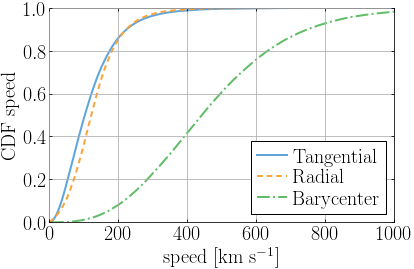

In [44]:
n = len(all_tan_vel)
plt.plot(np.sort(all_tan_vel), np.linspace(1.0/n,1,n), linestyle='-', label='Tangential')
plt.plot(np.sort(np.abs(all_rad_vel)), np.linspace(1.0/n,1,n), linestyle='--', label='Radial')
plt.plot(np.sort(np.abs(all_pec_vel)), np.linspace(1.0/n,1,n), linestyle='-.', label='Barycenter')

plt.xlim([0,1000])
plt.ylim([0,1])
plt.legend()
plt.xlabel("speed [km s$^{-1}$]")
plt.ylabel("CDF speed")
plt.grid()
plt.tight_layout()
plt.savefig("cdf_speed.pdf")

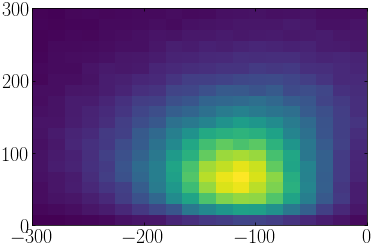

In [43]:
_ = plt.hist2d(all_rad_vel, all_tan_vel, range=[[-300,0],[0,300]], bins=20)

(0.0, 1000.0)

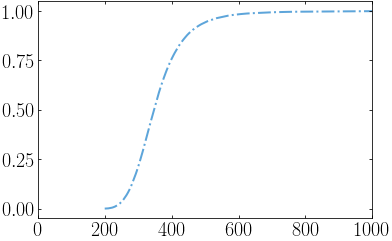

In [50]:
tot = np.sqrt((all_rad_vel-200)**2 + all_tan_vel**2)
plt.plot(np.sort(tot), np.linspace(1.0/n,1,n), linestyle='-.', label='Barycenter')
plt.xlim([0,1000])

In [4]:
n_bins = 26
pec_vel_bins = np.arange(0,1050,50)
n_bins = len(pec_vel_bins)
print(pec_vel_bins)
pec_vel_center = 0.5*(pec_vel_bins[1:]+pec_vel_bins[:-1])
mean_tan_vel = np.ones(n_bins-1)
error_tan_vel = np.ones(n_bins-1)
mean_rad_vel = np.ones(n_bins-1)
error_rad_vel = np.ones(n_bins-1)
mean_beta = np.ones(n_bins-1)
error_beta = np.ones(n_bins-1)

mean_mass = np.ones(n_bins-1)
error_mass = np.ones(n_bins-1)

for i in range(n_bins-1):
    min_pec_vel = pec_vel_bins[i]
    max_pec_vel = pec_vel_bins[i+1]
    ii = (all_pec_vel > min_pec_vel) & (all_pec_vel < max_pec_vel)
    mean_tan_vel[i] = np.median(all_tan_vel[ii])
    mean_rad_vel[i] = np.median(all_rad_vel[ii])
    mean_beta[i] = np.median(all_beta[ii])
    mean_mass[i] = np.median(all_tot_mass[ii])

    error_tan_vel[i] = error_median_bootstrap(all_tan_vel[ii])
    error_rad_vel[i] = error_median_bootstrap(all_rad_vel[ii])
    error_beta[i] = error_median_bootstrap(all_beta[ii])
    error_mass[i] = error_median_bootstrap(all_tot_mass[ii])

[   0   50  100  150  200  250  300  350  400  450  500  550  600  650
  700  750  800  850  900  950 1000]


[ 3.89522265e-05 -9.00457516e-03  9.74435166e+01]
[ 7.39592089e-06 -3.69582028e-04 -1.23874858e+02]
[-3.46081932e-07  1.10402255e-04  6.97178012e-01]


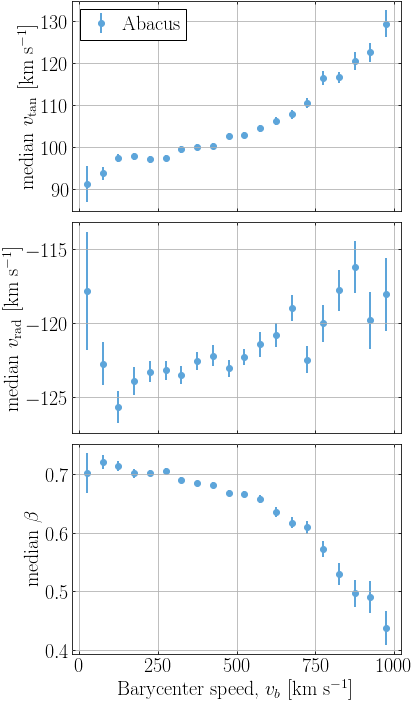

In [18]:
plt.figure(figsize=(6,10))

c = np.polyfit(pec_vel_center, mean_tan_vel, 2, w=1/error_tan_vel)
print(c)
fit_mean_tan_vel = pec_vel_center.copy()*0
for i in range(3):
    fit_mean_tan_vel += c[i] * pec_vel_center**(2-i)

ax1 = plt.subplot(3,1,1)
plt.errorbar(pec_vel_center, mean_tan_vel, error_tan_vel, fmt='o', label='Abacus')
#plt.errorbar(pec_vel_center, fit_mean_tan_vel, label='Best fit')
_=plt.yticks(np.arange(5)*10+ 90)
plt.setp(ax1.get_xticklabels(), visible=False)
plt.ylabel(r"median $v_{\mathrm{tan}}$ [km s$^{-1}$]")
plt.grid()
plt.legend()

c = np.polyfit(pec_vel_center, mean_rad_vel, 2, w=1/error_rad_vel)
print(c)
fit_mean_rad_vel = pec_vel_center.copy()*0
for i in range(3):
    fit_mean_rad_vel += c[i] * pec_vel_center**(2-i)


ax2 = plt.subplot(3,1,2, sharex=ax1)
# make these tick labels invisible
plt.setp(ax2.get_xticklabels(), visible=False)


plt.errorbar(pec_vel_center, mean_rad_vel, error_rad_vel, fmt='o')
#plt.errorbar(pec_vel_center, fit_mean_rad_vel)
plt.ylabel(r"median $v_{\mathrm{rad}}$ [km s$^{-1}$]")
#plt.xlabel(r"Barycenter speed $v_{b}$ [km s$^{-1}$]")
plt.grid()



c = np.polyfit(pec_vel_center, mean_beta, 2, w=1/error_beta)
print(c)
fit_beta = pec_vel_center.copy()*0
for i in range(3):
    fit_beta += c[i] * pec_vel_center**(2-i)

ax3 = plt.subplot(3,1,3, sharex=ax1)
# make these tick labels invisible
#plt.setp(ax2.get_xticklabels(), visible=False)


plt.errorbar(pec_vel_center, mean_beta, error_beta, fmt='o')
#plt.errorbar(pec_vel_center, fit_beta)
plt.ylabel(r"median $\beta$")
plt.xlabel(r"Barycenter speed, $v_{b}$ [km s$^{-1}$]")
plt.grid()
plt.tight_layout()
plt.savefig("rad_tan.pdf")

[ 1.97333061e-05 -3.56209797e-03  6.89285611e+02]


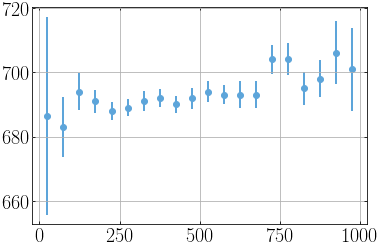

In [19]:
c = np.polyfit(pec_vel_center, mean_mass, 2, w=1/error_mass)
print(c)
fit_mean_mass = pec_vel_center.copy()*0
for i in range(3):
    fit_mean_mass += c[i] * pec_vel_center**(2-i)
    

plt.errorbar(pec_vel_center, mean_mass, error_mass, fmt='o')
#plt.errorbar(pec_vel_center, fit_mean_mass)
plt.grid()

In [7]:
(1/68.0)*100

1.4705882352941175

646
103 +88, -56
106 +89 -58
96 +85 -55


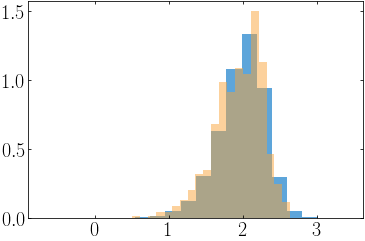

In [7]:
ii = (all_pec_vel>600) & (all_pec_vel<650) &  (all_rad_vel<-105) & (all_rad_vel>-115)
jj = (all_pec_vel>600) & (all_pec_vel<650) 

print(np.count_nonzero(ii))
_ = plt.hist(np.log10(all_tan_vel), bins=20, density=True)
_ = plt.hist(np.log10(all_tan_vel[ii]), bins=20, density=True, alpha=0.50)
p = np.percentile(all_tan_vel, q=[16,50,84])
print('{} +{}, -{}'.format(int(p[1]),  int(p[2]-p[1]), int(p[1]-p[0])))

p = np.percentile(all_tan_vel[jj], q=[16,50,84])
print('{} +{} -{}'.format(int(p[1]),  int(p[2]-p[1]), int(p[1]-p[0])))


p = np.percentile(all_tan_vel[ii], q=[16,50,84])
print('{} +{} -{}'.format(int(p[1]),  int(p[2]-p[1]), int(p[1]-p[0])))


646
-122 +58, -73
-120 +58 -75
-109 +3 -3


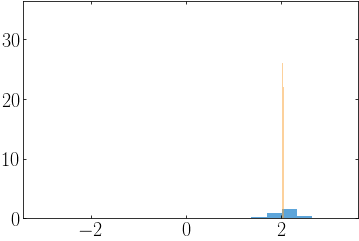

In [8]:
ii = (all_pec_vel>600) & (all_pec_vel<650) &  (all_rad_vel<-105) & (all_rad_vel>-115)
jj = (all_pec_vel>600) & (all_pec_vel<650) 

print(np.count_nonzero(ii))
_ = plt.hist(np.log10(-all_rad_vel), bins=20, density=True)
_ = plt.hist(np.log10(-all_rad_vel[ii]), bins=20, density=True, alpha=0.50)
p = np.percentile(all_rad_vel, q=[16,50,84])
print('{} +{}, -{}'.format(int(p[1]),  int(p[2]-p[1]), int(p[1]-p[0])))

p = np.percentile(all_rad_vel[jj], q=[16,50,84])
print('{} +{} -{}'.format(int(p[1]),  int(p[2]-p[1]), int(p[1]-p[0])))


p = np.percentile(all_rad_vel[ii], q=[16,50,84])
print('{} +{} -{}'.format(int(p[1]),  int(p[2]-p[1]), int(p[1]-p[0])))


646
0.66 +0.28, -1.89
0.64 +0.30, -2.06
0.63 +0.30, -1.00


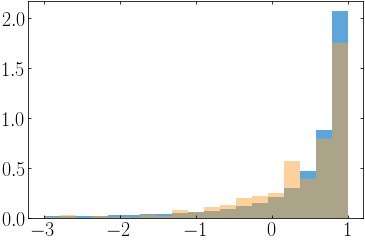

In [9]:
ii = (all_pec_vel>600) & (all_pec_vel<650) & (all_rad_vel<-105) & (all_rad_vel>-115)
jj = (all_pec_vel>600) & (all_pec_vel<650) 

print(np.count_nonzero(ii))
_ = plt.hist((all_beta), bins=np.linspace(-3,1,20), density=True)
_ = plt.hist((all_beta[ii]), bins=np.linspace(-3,1,20), density=True, alpha=0.50)
p = np.percentile(all_beta, q=[16,50,84])
print('{:.2f} +{:.2f}, -{:.2f}'.format(p[1],  p[2]-p[1], p[1]-p[0]))

p = np.percentile(all_beta[jj], q=[16,50,84])
print('{:.2f} +{:.2f}, -{:.2f}'.format(p[1],  p[2]-p[1], p[1]-p[0]))

p = np.percentile(all_beta[ii], q=[16,50,84])
print('{:.2f} +{:.2f}, -{:.2f}'.format(p[1],  p[2]-p[1], p[1]-p[0]))



In [10]:
v_trans = np.random.normal(loc=82.4, scale=31.2, size=np.count_nonzero(ii))
v_radial = np.random.normal(loc=-109.3, scale=4.0, size=np.count_nonzero(ii))
b = 1.0 - 0.5*(v_trans**2)/(v_radial**2)
print(np.percentile(b, q=[16,50,84]))


[0.43114621 0.68969431 0.88489669]


In [21]:
v_rad_hestia = np.array([-61.7, -68.8, -10.3, -76.1, -87.3, -76.4, -103.9, 
                         -26.9, -104.4, -17.0, -23.4, -26.6, -41.1])
v_tan_hestia = np.array([48.3, 59.5, 28.3, 55.7, 44.8, 12.1, 13.9, 12.6, 14.1, 
                        68.8, 87.5, 81.4, 89.8])

beta_hestia = 1.0-0.5*(v_tan_hestia**2)/(v_rad_hestia**2)

v_tan_elvis = np.array([ 173.6, 132.4, 13.2, 62.9, 38.6, 37.7, 42.4, 71.0, 42.0, 43.7, 11.0, 57.6])

In [22]:
np.median(v_tan_hestia), np.median(v_tan_elvis)

(48.3, 43.05)

(-7.0, 1.0)

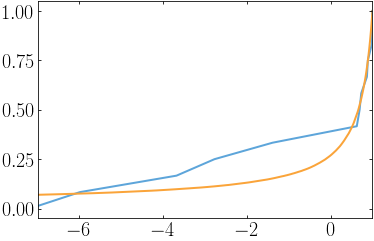

In [13]:
ii = (all_pec_vel>600) & (all_pec_vel<650) & (all_rad_vel<-105) & (all_rad_vel>-115)
plt.plot(np.sort(beta_hestia), np.linspace(0,1,len(beta_hestia)))
plt.plot(np.sort(all_beta), np.linspace(0,1,len(all_beta)))
plt.xlim([-7,1])



#plt.scatter(all_tan_vel[ii])